# Ejercicio 4
## Analizamos cómo el modelo representa aspectos de la distribución de una variable (Climatologia)

En esta sección vamos a considerar un área de trabajo, que corresponde a SESA (Sudeste de Sudámerica) y a partir de un rango de días de pronóstico y un plazo de 10 años, vamos a ver como se comporta esa climatología con los valores obtenidos para un año en particular.

Al igual que venimos haciendo en otros ejercicios, vamos a intentar trabajar sin descargar los datos y guardando en una variables que nos permita posteriormente procesar y graficar la figura que necesitamos.

Vamos a comenzar primero detallando algunas variables para 

In [14]:
# Como siempre, partimos importando los modulos a utilizar:
%matplotlib inline
import xarray as xr
import s3fs
import netCDF4
import numpy as np
import pandas as pd
import os
import datetime as dt
import matplotlib.pyplot as plt
import glob

# DATOS
BUCKET_NAME = 'sissa-forecast-database'
tforecast = 'subseasonal'
m0 = 'ERA5'
m1 = 'GEFSv12'
m2 = 'GEFSv12_corr'
variable = 'tmax'
years = np.arange(2010, 2020)

path0 = m0 + '/' + variable + '/' 
path1 = tforecast + '/' + m1 + '/' + variable + '/' 
path2 = tforecast + '/' + m2 + '/' + variable + '/' 

# Colocamos un área para SESA
lat_n = -20.
lat_s = -30.
lon_w = -65.
lon_e = -55.

#Fecha de referencia:
ref_date = dt.datetime(2010,12,1)


print('Carpeta con datos ERA5:', BUCKET_NAME + '/' + path0)
print('Carpeta con datos GEFSv12 sin corregir:', BUCKET_NAME + '/' + path1)
print('Carpeta con datos GEFSv12 corregidos:', BUCKET_NAME + '/' + path2)

Carpeta con datos ERA5: sissa-forecast-database/ERA5/tmax/
Carpeta con datos GEFSv12 sin corregir: sissa-forecast-database/subseasonal/GEFSv12/tmax/
Carpeta con datos GEFSv12 corregidos: sissa-forecast-database/subseasonal/GEFSv12_corr/tmax/


**Descarga de datos subset**

Los siguientes bloques corresponderan a las lineas de codigo para descargar los datos necesarios para revisar la climatologia del mes de diciembre
y vamos a analizar como se ven las dos primeras semanas de pronostico.

Creamos una carpeta temporal dentro de nuestra carpeta de trabajo.

Partimos descargando **ERA5**

Seguimos con **GEFSv12**

y terminamos con **GEFSv12_corr**

In [15]:
tmp = './tmp/'
os.makedirs(tmp, exist_ok=True)

for year in years:
    fs = s3fs.S3FileSystem(anon=True)
    awsfile = 's3://' + BUCKET_NAME + '/' + path0 + str(year) + '.nc'
    print(awsfile)
    with fs.open(awsfile) as f:
        ncfile = tmp + 'era5_' + variable + '_' + str(year) + '.nc'
        if not os.path.isfile(ncfile):
            print('Descargando:', ncfile)
            era = xr.open_dataset(f)
            era = era.sel(latitude=slice(lat_n, lat_s), longitude=slice(lon_w, lon_e))
            era.to_netcdf(ncfile)
    

s3://sissa-forecast-database/ERA5/tmax/2010.nc
s3://sissa-forecast-database/ERA5/tmax/2011.nc
s3://sissa-forecast-database/ERA5/tmax/2012.nc
s3://sissa-forecast-database/ERA5/tmax/2013.nc
s3://sissa-forecast-database/ERA5/tmax/2014.nc
s3://sissa-forecast-database/ERA5/tmax/2015.nc
s3://sissa-forecast-database/ERA5/tmax/2016.nc
s3://sissa-forecast-database/ERA5/tmax/2017.nc
s3://sissa-forecast-database/ERA5/tmax/2018.nc
s3://sissa-forecast-database/ERA5/tmax/2019.nc


In [16]:
for year in years:
    fs = s3fs.S3FileSystem(anon=True)
    loop_date = ref_date.replace(year=year)
    while loop_date < (ref_date.replace(year=year) + dt.timedelta(days=30)):
        if loop_date.weekday() == 2:
            PATH = BUCKET_NAME + '/' + path1 + str(year) + '/' + loop_date.strftime('%Y%m%d') + '/'
            print(PATH)
            awsfiles = fs.ls('s3://' + PATH) 
            for ens, awsfile in enumerate(awsfiles):
                if not os.path.isfile('./tmp/uncal_' + variable + '_' + loop_date.strftime('%Y%m%d') + '_' + str(ens) + '.nc'):
                    with fs.open(awsfile) as f:
                        gefs = xr.open_dataset(f)
                        gefs = gefs.sel(lat=slice(lat_n, lat_s), lon=slice(lon_w, lon_e))
                        gefs['M'] = ens
                        ds = gefs[variable]
                        ds.to_netcdf('./tmp/uncal_' + variable + '_' + loop_date.strftime('%Y%m%d') + '_' + str(ens) + '.nc')
        loop_date += dt.timedelta(days=1)

sissa-forecast-database/subseasonal/GEFSv12/tmax/2010/20101201/
sissa-forecast-database/subseasonal/GEFSv12/tmax/2010/20101208/
sissa-forecast-database/subseasonal/GEFSv12/tmax/2010/20101215/
sissa-forecast-database/subseasonal/GEFSv12/tmax/2010/20101222/
sissa-forecast-database/subseasonal/GEFSv12/tmax/2010/20101229/
sissa-forecast-database/subseasonal/GEFSv12/tmax/2011/20111207/
sissa-forecast-database/subseasonal/GEFSv12/tmax/2011/20111214/
sissa-forecast-database/subseasonal/GEFSv12/tmax/2011/20111221/
sissa-forecast-database/subseasonal/GEFSv12/tmax/2011/20111228/
sissa-forecast-database/subseasonal/GEFSv12/tmax/2012/20121205/
sissa-forecast-database/subseasonal/GEFSv12/tmax/2012/20121212/
sissa-forecast-database/subseasonal/GEFSv12/tmax/2012/20121219/
sissa-forecast-database/subseasonal/GEFSv12/tmax/2012/20121226/
sissa-forecast-database/subseasonal/GEFSv12/tmax/2013/20131204/
sissa-forecast-database/subseasonal/GEFSv12/tmax/2013/20131211/
sissa-forecast-database/subseasonal/GEFS

In [17]:
for year in years:
    fs = s3fs.S3FileSystem(anon=True)
    loop_date = ref_date.replace(year=year)
    while loop_date < (ref_date.replace(year=year) + dt.timedelta(days=30)):
        if loop_date.weekday() == 2:
            PATH = BUCKET_NAME + '/' + path2 + str(year) + '/' + loop_date.strftime('%Y%m%d') + '/'
            print(PATH)
            awsfiles = fs.ls('s3://' + PATH) 
            for ens, awsfile in enumerate(awsfiles):
                if not os.path.isfile('./tmp/cal_' + variable + '_' + loop_date.strftime('%Y%m%d') + '_' + str(ens) + '.nc'):
                    with fs.open(awsfile) as f:
                        gefs = xr.open_dataset(f)
                        gefs = gefs.sel(lat=slice(lat_n, lat_s), lon=slice(lon_w, lon_e))
                        gefs['M'] = ens
                        ds = gefs[variable]
                        ds.to_netcdf('./tmp/cal_' + variable + '_' + loop_date.strftime('%Y%m%d') + '_' + str(ens) + '.nc')
        loop_date += dt.timedelta(days=1)

sissa-forecast-database/subseasonal/GEFSv12_corr/tmax/2010/20101201/
sissa-forecast-database/subseasonal/GEFSv12_corr/tmax/2010/20101208/
sissa-forecast-database/subseasonal/GEFSv12_corr/tmax/2010/20101215/
sissa-forecast-database/subseasonal/GEFSv12_corr/tmax/2010/20101222/
sissa-forecast-database/subseasonal/GEFSv12_corr/tmax/2010/20101229/
sissa-forecast-database/subseasonal/GEFSv12_corr/tmax/2011/20111207/
sissa-forecast-database/subseasonal/GEFSv12_corr/tmax/2011/20111214/
sissa-forecast-database/subseasonal/GEFSv12_corr/tmax/2011/20111221/
sissa-forecast-database/subseasonal/GEFSv12_corr/tmax/2011/20111228/
sissa-forecast-database/subseasonal/GEFSv12_corr/tmax/2012/20121205/
sissa-forecast-database/subseasonal/GEFSv12_corr/tmax/2012/20121212/
sissa-forecast-database/subseasonal/GEFSv12_corr/tmax/2012/20121219/
sissa-forecast-database/subseasonal/GEFSv12_corr/tmax/2012/20121226/
sissa-forecast-database/subseasonal/GEFSv12_corr/tmax/2013/20131204/
sissa-forecast-database/subseasona

**Funciones extra**

Usamos las mismas funciones creadas para trabajar con los archivos descargados, que permiten ayudar a concatenar los datos

In [18]:
# funcion para acomodar xarrays antes de concatenarlos
def preprocess_ds(ds):
    ds['S'] = ds.time.values[0]
    ds['time'] = ds.time.values - ds.time.values[0]
    ds = ds.rename({'time': 'leadtime'})
    return ds

**Extraccion de datos y generación de figura**

En esta parte vamos a ir cargando los tres datos a tres variables distintas y vamos a ver como da la distribución de cada uno de ellos

In [32]:
# abrimos todos los datos ERA5 y los concatenamos en la coordenada tiempo
era5_files = glob.glob('./tmp/era5_' + variable + '_20*.nc')
ds_era = xr.open_mfdataset('./tmp/era5_' + variable + '_20*.nc', engine='netcdf4', combine='nested', concat_dim='time')
ds_era = ds_era.compute()

for year in years: #  loops sobre los años
    print(year)
    loop_date = ref_date.replace(year=year) # Tomo el mes de diciembre
    while loop_date < (ref_date.replace(year=year) + dt.timedelta(days=30)): #loops sobre los dias de diciembre
        if loop_date.weekday() == 2: # si es miercoles, coincide con la fecha del pronostico
            if not os.path.isfile('./tmp/' + variable + '_era5_' + loop_date.strftime('%Y%m%d') + '.nc'):
                print('./tmp/' + variable + '_era5_' + loop_date.strftime('%Y%m%d') + '.nc')
                era = ds_era.sel(time=slice(loop_date + dt.timedelta(days=8), loop_date + dt.timedelta(days=14))) #elijo la segunda semana
                era['S'] = loop_date #defino una fecha de comienzo equivalente a la del pronóstico
                era['time'] = era['time'] - era['S'] # defino las fechas de la semana dos como dias a partir de S
                era.to_netcdf('./tmp/' + variable + '_era5_' + loop_date.strftime('%Y%m%d') + '.nc') # guardo
        loop_date += dt.timedelta(days=1)

2010
2011
2012
2013
2014
2015
2016
2017
2018
2019


In [33]:
# Lectura de datos NO CALIBRADOS
ds_uncal = xr.open_mfdataset('./tmp/uncal_' + variable + '*.nc', engine='netcdf4', combine='nested', concat_dim=['S'], preprocess=preprocess_ds)
# selecciono semana 2 (8-14 dias)
ds_uncal_w2 = ds_uncal.sel(leadtime=slice(np.timedelta64(8, 'D'), np.timedelta64(14, 'D')))
print(ds_uncal_w2)

<xarray.Dataset>
Dimensions:   (leadtime: 7, lat: 41, lon: 41, S: 462)
Coordinates:
  * leadtime  (leadtime) timedelta64[ns] 8 days 9 days ... 13 days 14 days
  * lat       (lat) float64 -20.0 -20.25 -20.5 -20.75 ... -29.5 -29.75 -30.0
  * lon       (lon) float64 -65.0 -64.75 -64.5 -64.25 ... -55.5 -55.25 -55.0
  * S         (S) datetime64[ns] 2010-12-01 2010-12-01 ... 2019-12-25 2019-12-25
Data variables:
    tmax      (S, leadtime, lat, lon) float64 dask.array<chunksize=(1, 7, 41, 41), meta=np.ndarray>


In [35]:
# Lectura de datos CALIBRADOS
ds_cal = xr.open_mfdataset('./tmp/cal_' + variable + '*.nc', engine='netcdf4', combine='nested', concat_dim=['S'], preprocess=preprocess_ds)
# selecciono semana 2 (8-14 dias)
ds_cal_w2 = ds_cal.sel(leadtime=slice(np.timedelta64(8, 'D'), np.timedelta64(14, 'D')))
print(ds_cal_w2)

<xarray.Dataset>
Dimensions:   (leadtime: 7, lat: 41, lon: 41, S: 462)
Coordinates:
  * leadtime  (leadtime) timedelta64[ns] 8 days 9 days ... 13 days 14 days
  * lat       (lat) float64 -20.0 -20.25 -20.5 -20.75 ... -29.5 -29.75 -30.0
  * lon       (lon) float64 -65.0 -64.75 -64.5 -64.25 ... -55.5 -55.25 -55.0
  * S         (S) datetime64[ns] 2010-12-01 2010-12-01 ... 2019-12-25 2019-12-25
Data variables:
    tmax      (S, leadtime, lat, lon) float64 dask.array<chunksize=(1, 7, 41, 41), meta=np.ndarray>


In [36]:
# Lectura de datos ERA5
ds_era = xr.open_mfdataset('./tmp/' + variable + '_era5_' + '*.nc', engine='netcdf4', combine='nested', concat_dim=['S'])
print(ds_era)

<xarray.Dataset>
Dimensions:    (time: 7, latitude: 41, longitude: 41, S: 42)
Coordinates:
  * time       (time) timedelta64[ns] 8 days 9 days 10 days ... 13 days 14 days
  * latitude   (latitude) float32 -20.0 -20.25 -20.5 ... -29.5 -29.75 -30.0
  * longitude  (longitude) float32 -65.0 -64.75 -64.5 ... -55.5 -55.25 -55.0
  * S          (S) datetime64[ns] 2010-12-01 2010-12-08 ... 2019-12-25
Data variables:
    tmax       (S, time, latitude, longitude) float64 dask.array<chunksize=(1, 1, 41, 41), meta=np.ndarray>


[Text(1, 0, 'ERA5'), Text(2, 0, 'GEFSv12'), Text(3, 0, 'GEFSv12_corr')]

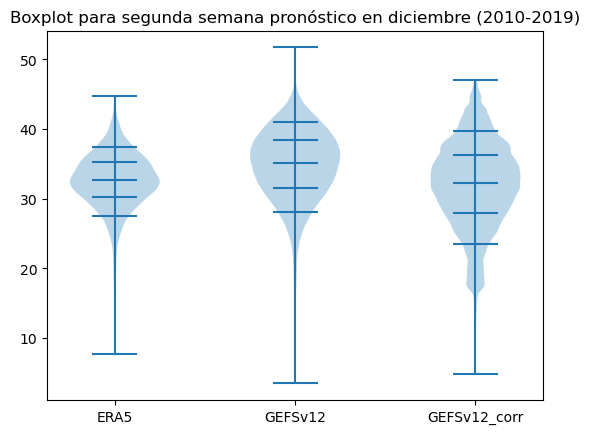

In [45]:
### Comenzamos a trabajar para hacer la figura

aux_uncal = ds_uncal_w2[variable].values.flat
aux_cal   = ds_cal_w2[variable].values.flat
aux_era   = ds_era[variable].values.flat[~np.isnan(ds_era[variable].values.flat)]
qc_t = [[0.1, 0.25, 0.75, 0.9], [0.1, 0.25, 0.75, 0.9], [0.1, 0.25, 0.75, 0.9]]
data = [aux_era, aux_uncal, aux_cal]

# Comenzamos la figura
fig, ax = plt.subplots()
parts = ax.violinplot(data, [1, 2, 3], showmeans=False, showmedians=True, quantiles=qc_t)
ax.set_title('Boxplot para segunda semana pronóstico en diciembre (2010-2019)')
ax.set_xticks([1, 2, 3])
ax.set_xticklabels(['ERA5', 'GEFSv12', 'GEFSv12_corr'])
#axs.set_title('notch=True,\nbootstrap=10000', fontsize=fs

#for pc in parts['bodies']:
#    pc.set_facecolor('#fa5305')
#    pc.set_edgecolor('black')
#    pc.set_alpha(1)